In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
# Load and preprocess dataset
df = pd.read_csv("./data/BTCUSDT_1h.csv")
df['close_time'] = pd.to_datetime(df['close_time'], errors='coerce')
df.sort_values('close_time')
data = df[['open', 'high', 'low', 'close', 'volume']].values

In [ ]:
# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# Create sequences
SEQ_LEN = 24  # 24 hours
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len][3]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, SEQ_LEN)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

In [ ]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)

In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1]
        return self.fc(out)

model = LSTMModel(input_size=5)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
early_stopper_patience = 10

In [9]:
# Training loop
train_losses, val_losses, lrs, rmse_values, mae_values = [], [], [], [], []
best_val_loss = np.inf
patience_counter = 0

for epoch in range(100):
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    model.eval()
    epoch_val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            epoch_val_loss += loss.item()
            preds.extend(pred.squeeze().tolist())
            targets.extend(yb.squeeze().tolist())

    rmse = np.sqrt(mean_squared_error(targets, preds))
    mae = mean_absolute_error(targets, preds)

    lr = optimizer.param_groups[0]['lr']
    scheduler.step(epoch_val_loss)

    train_losses.append(epoch_train_loss / len(train_loader))
    val_losses.append(epoch_val_loss / len(val_loader))
    lrs.append(lr)
    rmse_values.append(rmse)
    mae_values.append(mae)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, \n\tRMSE={rmse:.4f}, MAE={mae:.4f}, LR={lr:.5f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopper_patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss=0.0002, Val Loss=0.0002, 
	RMSE=0.0127, MAE=0.0108, LR=0.01000
Epoch 2: Train Loss=0.0000, Val Loss=0.0002, 
	RMSE=0.0132, MAE=0.0113, LR=0.01000
Epoch 3: Train Loss=0.0000, Val Loss=0.0002, 
	RMSE=0.0139, MAE=0.0124, LR=0.01000
Epoch 4: Train Loss=0.0000, Val Loss=0.0000, 
	RMSE=0.0068, MAE=0.0048, LR=0.01000
Epoch 5: Train Loss=0.0000, Val Loss=0.0001, 
	RMSE=0.0088, MAE=0.0070, LR=0.01000
Epoch 6: Train Loss=0.0000, Val Loss=0.0001, 
	RMSE=0.0071, MAE=0.0053, LR=0.01000
Epoch 7: Train Loss=0.0000, Val Loss=0.0000, 
	RMSE=0.0068, MAE=0.0049, LR=0.01000
Epoch 8: Train Loss=0.0000, Val Loss=0.0001, 
	RMSE=0.0086, MAE=0.0065, LR=0.01000
Epoch 9: Train Loss=0.0000, Val Loss=0.0000, 
	RMSE=0.0069, MAE=0.0050, LR=0.01000
Epoch 10: Train Loss=0.0000, Val Loss=0.0002, 
	RMSE=0.0132, MAE=0.0111, LR=0.01000
Epoch 11: Train Loss=0.0000, Val Loss=0.0002, 
	RMSE=0.0135, MAE=0.0116, LR=0.01000
Epoch 12: Train Loss=0.0000, Val Loss=0.0001, 
	RMSE=0.0091, MAE=0.0075, LR=0.01000
E

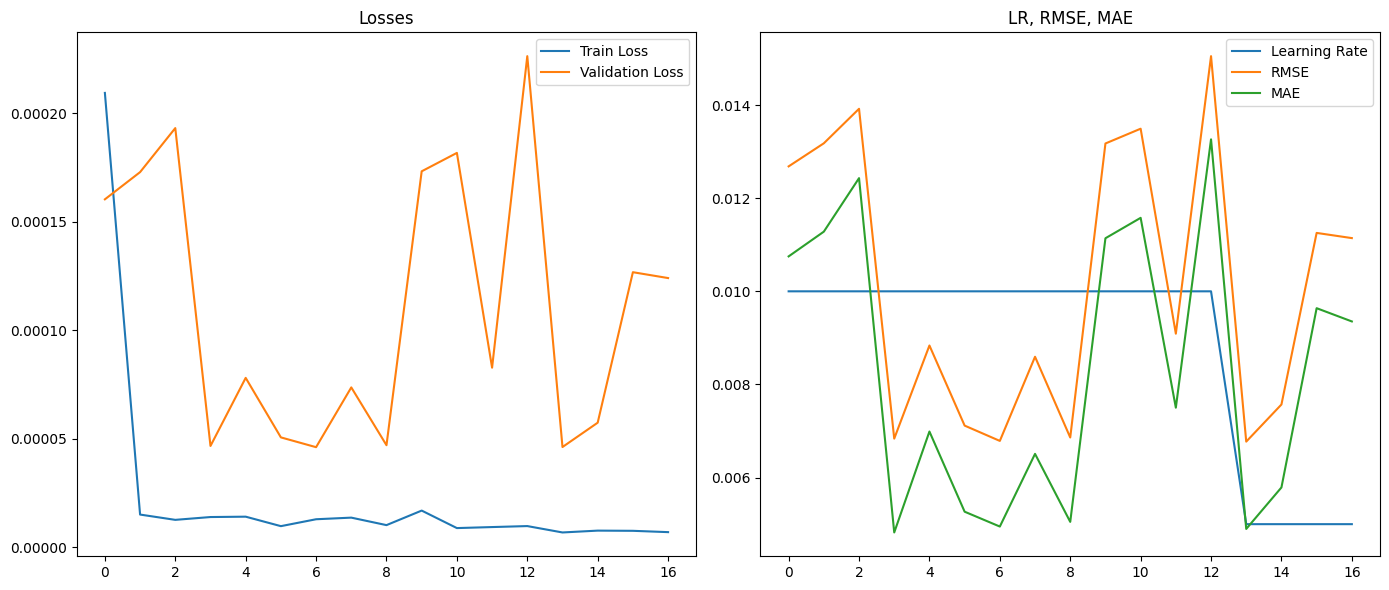

In [10]:
# Plot metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.plot(rmse_values, label='RMSE')
plt.plot(mae_values, label='MAE')
plt.legend()
plt.title('LR, RMSE, MAE')
plt.tight_layout()
plt.show()

Detected 139 anomalies using Z-score method.


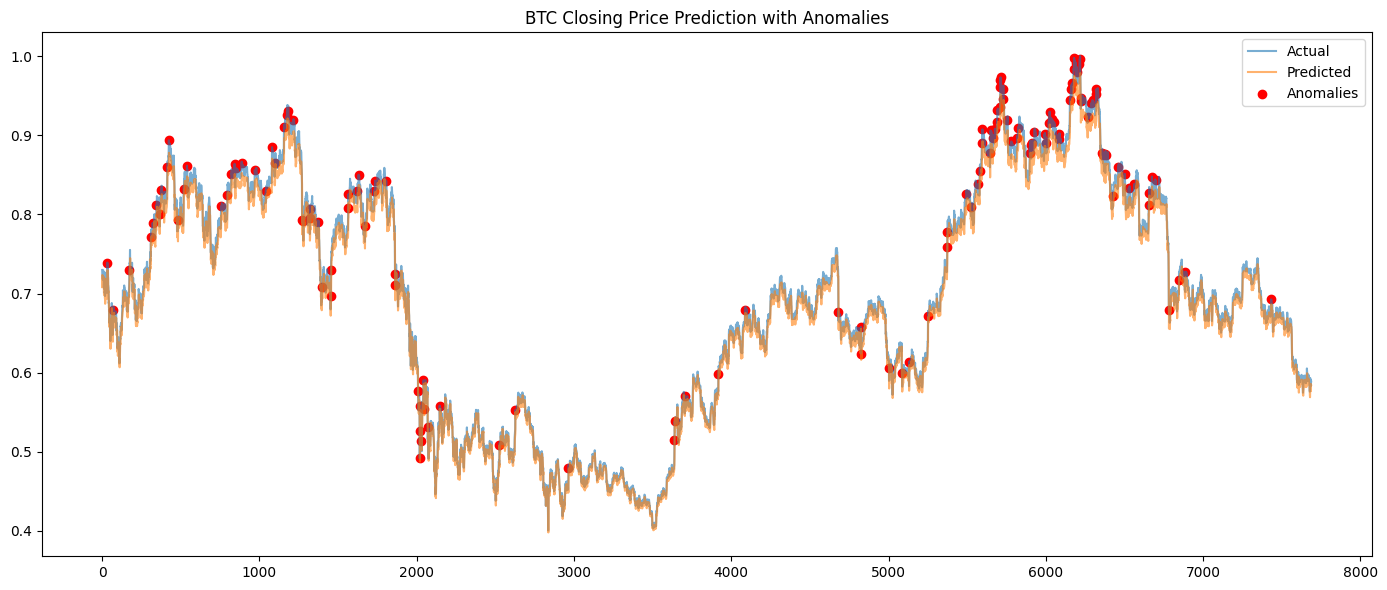

In [ ]:
# Detect anomalies using Z-score of residuals
errors = np.abs(np.array(targets) - np.array(preds))
mean_error = np.mean(errors)
std_error = np.std(errors)
z_scores = (errors - mean_error) / std_error

anomaly_threshold = 2.5 
anomalies = np.where(np.abs(z_scores) > anomaly_threshold)[0]

print(f"Detected {len(anomalies)} anomalies using Z-score method.")

# Plot with anomalies
plt.figure(figsize=(14, 6))
plt.plot(targets, label='Actual', alpha=0.6)
plt.plot(preds, label='Predicted', alpha=0.6)
plt.scatter(anomalies, np.array(targets)[anomalies], color='red', label='Anomalies')
plt.title("BTC Closing Price Prediction with Anomalies")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
base_index = split + SEQ_LEN
anomaly_times = df['close_time'].iloc[base_index + anomalies]
for time in anomaly_times:
    print("Anomaly detected at:", time)


Anomaly detected at: 2021-02-25 07:59:59.999000-05:00
Anomaly detected at: 2021-02-26 19:59:59.999000-05:00
Anomaly detected at: 2021-03-03 03:59:59.999000-05:00
Anomaly detected at: 2021-03-08 20:59:59.999000-05:00
Anomaly detected at: 2021-03-09 08:59:59.999000-05:00
Anomaly detected at: 2021-03-10 08:59:59.999000-05:00
Anomaly detected at: 2021-03-11 05:59:59.999000-05:00
Anomaly detected at: 2021-03-11 13:59:59.999000-05:00
Anomaly detected at: 2021-03-13 05:59:59.999000-05:00
Anomaly detected at: 2021-03-13 15:59:59.999000-05:00
Anomaly detected at: 2021-03-16 01:59:59.999000-05:00
Anomaly detected at: 2021-03-17 13:59:59.999000-05:00
Anomaly detected at: 2021-03-18 10:59:59.999000-05:00
Anomaly detected at: 2021-03-27 11:59:59.999000-05:00
Anomaly detected at: 2021-03-29 03:59:59.999000-05:00
Anomaly detected at: 2021-03-30 04:59:59.999000-05:00
Anomaly detected at: 2021-03-31 01:59:59.999000-05:00
Anomaly detected at: 2021-03-31 10:59:59.999000-05:00
Anomaly detected at: 2021-04

In [ ]:
anomaly_df = df.iloc[base_index + anomalies].copy()
anomaly_df['predicted_close'] = np.array(preds)[anomalies]
anomaly_df['actual_close'] = np.array(targets)[anomalies]
anomaly_df['abs_error'] = np.abs(anomaly_df['actual_close'] - anomaly_df['predicted_close'])

anomaly_df.to_csv("results/lstm_anomalies.csv", index=False)
print("Anomalies saved to lstm_anomalies.csv")


Anomalies saved to btc_anomalies.csv


In [ ]:
df2 = pd.read_csv("results/lstm_anomalies.csv")

In [4]:
df2.head()

,open,high,low,close,volume,close_time,quote,takers_buy_base,takers_buy_quote,predicted_close,actual_close,abs_error
0,50299.00,51500.00,50077.00,51487.06,5006.691965,2021-02-25 07:59:59.999000-05:00,2.539288e+08,2750.041840,1.395109e+08,0.711383,0.739075,0.027691
1,46276.88,47568.18,46156.24,47525.07,3534.299991,2021-02-26 19:59:59.999000-05:00,1.658036e+08,1665.015671,7.811064e+07,0.653424,0.678784,0.025360
2,49752.97,50998.00,49752.97,50909.41,5488.749346,2021-03-03 03:59:59.999000-05:00,2.770244e+08,3143.494511,1.585821e+08,0.705035,0.730284,0.025249
3,52020.24,53760.00,51981.26,53575.35,7510.120433,2021-03-08 20:59:59.999000-05:00,3.992837e+08,3768.113098,2.001647e+08,0.737378,0.770853,0.033475
4,53725.49,54815.84,53664.21,54779.99,4188.622682,2021-03-09 08:59:59.999000-05:00,2.277232e+08,2150.280537,1.168439e+08,0.763105,0.789184,0.026079
